In [412]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 0. Data loading and cleaning

In [413]:
# Data loading
path = r'../data/raw/data_raw.csv'
alzheimer_df = pd.read_csv(path)

In [414]:
#Filtering only the rows about alzheimers disease
alzheimer_df = alzheimer_df[alzheimer_df["Padecimiento"].str.startswith("Enfermedad de Alzheimer", na=False)]

In [415]:
#cleaning innecesary columns
alzheimer_df = alzheimer_df.drop(["Pag.", "Cuadro ", "No_01", "No_02", "No_03", "No_04", "Ax_001", "Ax_002", "Padecimiento"], axis=1)

In [416]:
# replacing "-" by "0"
alzheimer_df["Valor"] = alzheimer_df["Valor"].replace("-", "0")

# converting to numeric data type
alzheimer_df["Valor"] = pd.to_numeric(alzheimer_df["Valor"], errors="coerce")

In [417]:
# Converting "Semana" to a numeric data type
alzheimer_df["Semana"] = alzheimer_df["Semana"].str.replace("sem", "", regex=False).astype(int)

In [418]:
# replacing Entidad name 
alzheimer_df["Entidad"] = alzheimer_df["Entidad"].replace("Distrito Federal", "Ciudad de México")

In [419]:
# Removing redundant data

# Removing rows with "Acum." in "Ax_003" column
alzheimer_df = alzheimer_df[alzheimer_df["Ax_003"] != "Acum."]

# Removing rows with "TOTAL" in "Entidad" column
alzheimer_df = alzheimer_df[alzheimer_df["Entidad"] != "TOTAL"]

In [420]:
# Pivot Ax_003 to get separate columns for each category
alzheimer_df = alzheimer_df.pivot_table(
    index=["Año", "Semana", "Entidad"],
    columns="Ax_003",
    values="Valor",
    aggfunc="first"
).reset_index()

alzheimer_df = alzheimer_df.rename(columns={
    "Sem.": "Casos_Semanal_Total",
    "H": "Casos_Acum_Hombres",
    "M": "Casos_Acum_Mujeres"
})

alzheimer_df.columns.name = None

# Se eliminan las columnas de acumulados por género
alzheimer_base_df = alzheimer_df.drop(columns=['Casos_Acum_Hombres', 'Casos_Acum_Mujeres'])

print("DataFrame simplificado, solo con casos totales por entidad:")
alzheimer_base_df.head()

DataFrame simplificado, solo con casos totales por entidad:


,Año,Semana,Entidad,Casos_Semanal_Total
0,2014,2,Aguascalientes,0.0
1,2014,2,Baja California,0.0
2,2014,2,Baja California Sur,0.0
3,2014,2,Campeche,0.0
4,2014,2,Chiapas,0.0


Tras el proceso de carga, exploración y limpieza de los datos crudos, hemos consolidado un DataFrame final, alzheimer_base_df, que servirá como el punto de partida para la fase de Ingeniería de Características (FE). La estructura de este DataFrame es el resultado de una serie de decisiones metodológicas deliberadas, diseñadas para asegurar la interpretabilidad y manejabilidad del proyecto.

El DataFrame alzheimer_base_df se caracteriza por tener las siguientes columnas: Año, Semana, Entidad y Casos_Semanal_Total. Cada fila representa el número total de nuevos casos de Alzheimer reportados en una semana epidemiológica específica para una de las 32 entidades federativas de México.

La elección de esta estructura se fundamenta en las siguientes razones estratégicas:

- Consolidación y Claridad: El proceso inicial de pivoteo transformó los datos de un formato "largo" a uno "ancho", eliminando la redundancia y presentando la métrica clave —Casos_Semanal_Total— de manera explícita. Esto mejora la legibilidad y facilita las operaciones de análisis posteriores.
- Enfoque en el Problema Principal: Durante el análisis inicial, se identificaron datos acumulados por género. Si bien esta información es valiosa, se tomó la decisión estratégica de excluirla en esta etapa inicial. Este enfoque, centrado en un modelo univariado por entidad, nos permite:
    - Establecer un Modelo de Referencia (Baseline): Construir y evaluar un modelo predictivo basado en la serie de tiempo total de casos servirá como una métrica base sólida contra la cual se podrán comparar futuras iteraciones más complejas.
    - Reducir la Complejidad Inicial: Añadir la granularidad de género duplicaría la cantidad de series a modelar, incrementando la complejidad computacional y conceptual del proyecto. Siguiendo principios de desarrollo iterativo, es preferible resolver el problema central primero y luego añadir capas de complejidad de forma controlada.

## 1. Generación de nuevas características

### Columnas de naturaleza temporal conforme al Año y Semana

In [421]:
# Partimos del DataFrame 'alzheimer_base_df'

# Se crea una columna de Fecha
alzheimer_base_df['Semana_Str'] = alzheimer_base_df['Semana'].astype(str).str.zfill(2)
alzheimer_base_df['Fecha'] = pd.to_datetime(
    alzheimer_base_df['Año'].astype(str) + alzheimer_base_df['Semana_Str'] + '0', 
    format='%Y%U%w'
)

# Se identifican duplicados basados en la combinación de 'Entidad' y 'Fecha'
duplicados_mask = alzheimer_base_df.duplicated(subset=['Entidad', 'Fecha'], keep=False)

registros_duplicados = alzheimer_base_df[duplicados_mask]

if not duplicados_mask.any():
    print("No se encontraron fechas duplicadas para ninguna entidad.")
    df_fe = alzheimer_base_df.copy()
else:
    print(f"Se encontraron {duplicados_mask.sum()} registros involucrados en duplicaciones.")
    # Se agrupa por Entidad y Fecha, sumando los casos y tomando el primer valor para los demás.
    agregaciones = {
        'Año': 'first',
        'Semana': 'first',
        'Casos_Semanal_Total': 'sum'
    }
    df_fe = alzheimer_base_df.groupby(['Entidad', 'Fecha']).agg(agregaciones).reset_index()
    print("DataFrame consolidado y sin duplicados.")

# Se crean Características con naturaleza temporal
df_fe['Mes'] = df_fe['Fecha'].dt.month
df_fe['Trimestre'] = df_fe['Fecha'].dt.quarter

# Ordenamiento y Limpieza Final
df_fe.sort_values(by=['Entidad', 'Fecha'], inplace=True)
df_fe = df_fe[['Fecha', 'Entidad', 'Año', 'Semana', 'Mes', 'Trimestre', 'Casos_Semanal_Total']].copy()

df_fe.head()

Se encontraron 128 registros involucrados en duplicaciones.
DataFrame consolidado y sin duplicados.


,Fecha,Entidad,Año,Semana,Mes,Trimestre,Casos_Semanal_Total
0,2014-01-12,Aguascalientes,2014,2,1,1,0.0
1,2014-01-19,Aguascalientes,2014,3,1,1,0.0
2,2014-01-26,Aguascalientes,2014,4,1,1,0.0
3,2014-02-02,Aguascalientes,2014,5,2,1,0.0
4,2014-02-09,Aguascalientes,2014,6,2,1,0.0


COLUMNA "FECHA".

El conjunto de datos original representaba el tiempo a través de dos columnas discretas: Año y Semana. Para un análisis riguroso de series de tiempo, es indispensable contar con un índice temporal formal que represente la secuencia continua de los eventos. Por lo tanto, se combinaron las columnas Año y Semana para generar una única columna Fecha de tipo datetime. Esta columna ancla cada observación a un punto específico en el tiempo, en este caso, al inicio de cada semana epidemiológica.

La creación de una variable datetime formaliza la estructura de la serie de tiempo, permitiendo un ordenamiento cronológico, lo que más adelante será útil en el cálculo de variables de retraso (lags) y ventanas móviles, que dependen de la secuencia ordenada de los datos.

MANEJO DE REGISTROS DUPLICADOS.

Un análisis exploratorio previo sugirió la posible existencia de registros duplicados a nivel de entidad y fecha. La presencia de duplicados puede distorsionar las estadísticas descriptivas e introducir un sesgo significativo en el entrenamiento del modelo.

Se implementó una verificación para identificar todas las filas donde la combinación Entidad y Fecha no era única. Se descubrió que estos duplicados surgían de inconsistencias en el reporte de la "semana 53" en ciertos años, la cual se traslapaba con la primera semana del año subsecuente. Para rectificar esto, se sumaron los Casos_Semanal_Total de dichos duplicados y se mantuvo el primer valor para las demás dimensiones descriptivas.

GENERACIÓN DE CARACTERÍSTICAS DERIVADAS.

Aunque el índice Fecha captura la secuencia, no expone de manera explícita los patrones cíclicos inherentes al calendario (ej. mensual, trimestral). Los modelos de Machine Learning, a diferencia de los modelos estadísticos clásicos de series de tiempo, no infieren estos ciclos automáticamente y se benefician enormemente de tenerlos como variables predictoras explícitas.

Por lo tanto, se derivaron tres nuevas características numéricas a partir de la columna Fecha: Mes, Semana_del_Año y Trimestre. Estas características convierten la información cíclica del tiempo en un formato numérico que los algoritmos de aprendizaje automático pueden utilizar directamente. Permiten al modelo identificar y cuantificar patrones estacionales o cíclicos que no son estrictamente anuales.

### Características de Lags y Ventanas Móviles

In [422]:
# Se parte del DataFrame df_fe, que ya contiene características temporales conforme a la fecha

# Se crean Lags y Ventanas Móviles

# Creación de Lags
# Se usa un bucle para crear lags desde 1 hasta 4 semanas atrás.
for i in range(1, 5):
    df_fe[f'Lag_{i}'] = df_fe.groupby('Entidad')['Casos_Semanal_Total'].shift(i)

# Creación de Ventanas Móviles
# Se define el tamaño de la ventana (4 semanas para un mes).
ventana = 4
# Se calcula la media y desviación estándar móvil.
df_fe[f'Media_Movil_{ventana}'] = df_fe.groupby('Entidad')['Casos_Semanal_Total'].rolling(window=ventana).mean().reset_index(level=0, drop=True)
df_fe[f'Std_Movil_{ventana}'] = df_fe.groupby('Entidad')['Casos_Semanal_Total'].rolling(window=ventana).std().reset_index(level=0, drop=True)


# Limpieza Final de NaNs
# Se eliminan todas las filas que contengan cualquier valor NaN generado en los pasos anteriores.
# Los Nan ocurren debido a que los primeros regitros de cada estado no cuentan con los 4 datos históricos anteriores.
# Esto asegura que el DataFrame final solo contiene registros completos.
df_fe.dropna(inplace=True)

In [423]:
# Filtrado de ejemplo para ver valores en las nuevas columnas

# Inspección de un punto de datos en la serie

# Se definen los criterios de filtrado
entidad_interes = 'Puebla'
año_interes = 2015
# Se selecciona un rango de semanas para dar contexto
rango_semanas = range(35, 41) 

# Se aplica el filtro sobre el DataFrame 'df_fe'
ejemplo_df = df_fe[
    (df_fe['Entidad'] == entidad_interes) &
    (df_fe['Año'] == año_interes) &
    (df_fe['Semana'].isin(rango_semanas))
]

print(f"Inspeccionando datos para '{entidad_interes}' en las semanas {rango_semanas.start}-{rango_semanas.stop-1} de {año_interes}:\n")
print(ejemplo_df)

Inspeccionando datos para 'Puebla' en las semanas 35-40 de 2015:

           Fecha Entidad   Año  Semana  Mes  Trimestre  Casos_Semanal_Total  \
11485 2015-08-30  Puebla  2015      35    8          3                  2.0   
11486 2015-09-06  Puebla  2015      36    9          3                  1.0   
11487 2015-09-13  Puebla  2015      37    9          3                  1.0   
11488 2015-09-20  Puebla  2015      38    9          3                  2.0   
11489 2015-09-27  Puebla  2015      39    9          3                  4.0   
11490 2015-10-04  Puebla  2015      40   10          4                  0.0   

       Lag_1  Lag_2  Lag_3  Lag_4  Media_Movil_4  Std_Movil_4  
11485    2.0    0.0    1.0    2.0           1.25     0.957427  
11486    2.0    2.0    0.0    1.0           1.25     0.957427  
11487    1.0    2.0    2.0    0.0           1.50     0.577350  
11488    1.0    1.0    2.0    2.0           1.50     0.577350  
11489    2.0    1.0    1.0    2.0           2.00     1.41421

INCORPORACIÓN DE COLUMAS "LAGS".

Se han incorporado al conjunto de datos nuevas columnas denominadas "lags" o características de retraso. Estas variables contienen los valores de Casos_Semanal_Total de semanas anteriores para cada entidad.

La utilidad de estas características viene pensando en el futuro modelado de series de tiempo con algoritmos de aprendizaje automático:
- Capturan la Autocorrelación: La premisa fundamental es que el valor de una serie temporal en un punto dado está fuertemente influenciado por sus valores inmediatamente anteriores. Los lags traducen esta dependencia temporal (autocorrelación) a un formato que el modelo puede interpretar directamente.
- Contextualizan la Serie: Permiten al modelo "ver" la trayectoria reciente de los datos (si los casos vienen subiendo, bajando o se mantienen estables) al momento de hacer una predicción para una nueva semana.

INCORPORACIÓN DE COLUMNAS "VENTANAS MÓVILES".

Para complementar la información puntual de los lags, se han añadido al DataFrame características de ventana móvil, específicamente la media y la desviación estándar de los casos en las últimas cuatro semanas.

Se busca que estas variables enriquezcan el contexto que el modelo tendrá para cada predicción:
- Captura de la Tendencia Local (Media Móvil): La Media_Movil suaviza las fluctuaciones semanales y le proporciona al modelo una señal clara sobre la dirección de la tendencia reciente para cada entidad.
- Medición de la Volatilidad (Desviación Estándar Móvil): La Std_Movil cuantifica la estabilidad de la serie en el período reciente. Un valor alto le indica al modelo que los casos han sido erráticos e impredecibles, mientras que un valor bajo sugiere un comportamiento más estable y consistente.

## 2. Codificación One Hot Encoding para la variable 'Entidad'

In [424]:
# Se parte del DataFrame df_fe, que contiene todas las características generadas.

# Se aplica One-Hot Encoding a la columna 'Entidad'

# Se utiliza pd.get_dummies() para crear las nuevas columnas binarias.
# El argumento 'dtype=int' asegura que los valores sean 0 y 1.
df_codificado = pd.get_dummies(df_fe, columns=['Entidad'], prefix='Entidad', dtype=int)

print("DataFrame con la columna 'Entidad' codificada:")
# Se muestran las primeras filas y algunas de las nuevas columnas.
print(df_codificado.head())

print(f"\nEl número de columnas ha aumentado de {df_fe.shape[1]} a {df_codificado.shape[1]}.")

DataFrame con la columna 'Entidad' codificada:
       Fecha   Año  Semana  Mes  Trimestre  Casos_Semanal_Total  Lag_1  Lag_2  \
4 2014-02-09  2014       6    2          1                  0.0    0.0    0.0   
5 2014-02-16  2014       7    2          1                  0.0    0.0    0.0   
6 2014-02-23  2014       8    2          1                  0.0    0.0    0.0   
7 2014-03-02  2014       9    3          1                  0.0    0.0    0.0   
8 2014-03-09  2014      10    3          1                  0.0    0.0    0.0   

   Lag_3  Lag_4  ...  Entidad_Quintana Roo  Entidad_San Luis Potosí  \
4    0.0    0.0  ...                     0                        0   
5    0.0    0.0  ...                     0                        0   
6    0.0    0.0  ...                     0                        0   
7    0.0    0.0  ...                     0                        0   
8    0.0    0.0  ...                     0                        0   

   Entidad_Sinaloa  Entidad_Sonora  Ent

CODIFICACIÓN DE 'ENTIDAD'.

Para que el algoritmo de aprendizaje automático pueda utilizar la variable Entidad como predictora, es necesario convertirla de su formato categórico (texto) a una representación numérica.

La técnica seleccionada para esta tarea es One-Hot Encoding. Se optó por este método debido a que las entidades federativas no poseen una relación de orden o jerarquía.

A diferencia de otras técnicas como la codificación ordinal, el One-Hot Encoding evita introducir un sesgo artificial en el modelo al crear columnas binarias (0 o 1) independientes para cada estado. Esto permite que el modelo aprenda la influencia particular de cada entidad en los casos de Alzheimer sin asumir una falsa relación ordinal entre ellas.

## 3. Transformación Logarítmica de la Variable Objetivo

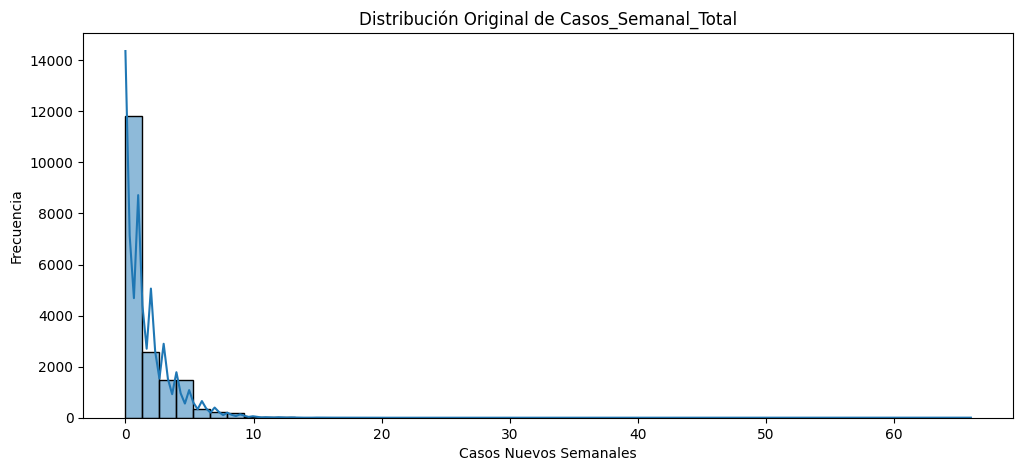

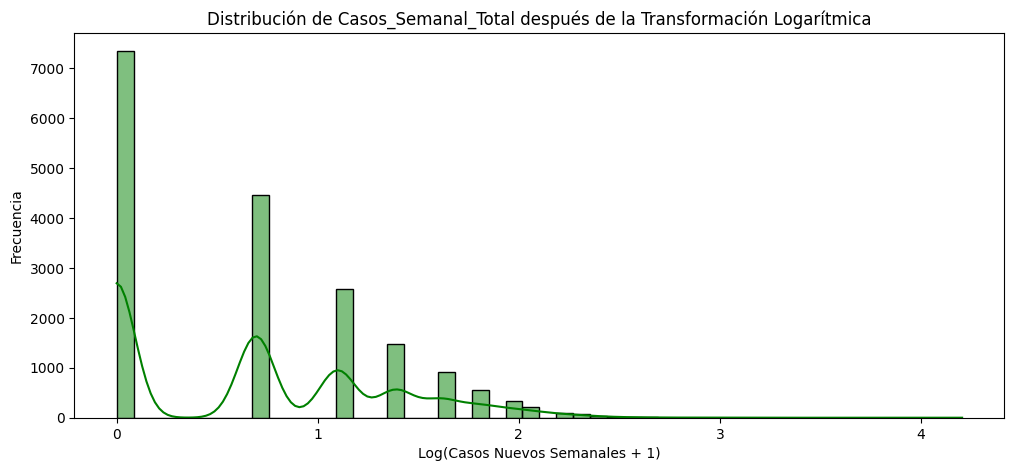

In [425]:
# Se parte del DataFrame df_codificado

# Se analiza y transforma la variable objetivo

# Se visualiza la distribución original de los casos
plt.figure(figsize=(12, 5))
sns.histplot(df_codificado['Casos_Semanal_Total'], kde=True, bins=50)
plt.title('Distribución Original de Casos_Semanal_Total')
plt.xlabel('Casos Nuevos Semanales')
plt.ylabel('Frecuencia')
plt.show()

# Se aplica la transformación logarítmica
# Se usa np.log1p para manejar correctamente los valores de 0 (calcula log(1+x))
df_codificado['Casos_Log'] = np.log1p(df_codificado['Casos_Semanal_Total'])

# Se visualiza la nueva distribución
plt.figure(figsize=(12, 5))
sns.histplot(df_codificado['Casos_Log'], kde=True, bins=50, color='green')
plt.title('Distribución de Casos_Semanal_Total después de la Transformación Logarítmica')
plt.xlabel('Log(Casos Nuevos Semanales + 1)')
plt.ylabel('Frecuencia')
plt.show()

In [426]:
# Se elimina la columna original para evitar fuga de datos
df_preparado = df_codificado.drop(columns=['Casos_Semanal_Total'])

print("DataFrame final luego de la transformación logarítmica a la variable target de casos")
df_preparado.head()

DataFrame final luego de la transformación logarítmica a la variable target de casos


,Fecha,Año,Semana,Mes,Trimestre,Lag_1,Lag_2,Lag_3,Lag_4,Media_Movil_4,...,Entidad_San Luis Potosí,Entidad_Sinaloa,Entidad_Sonora,Entidad_Tabasco,Entidad_Tamaulipas,Entidad_Tlaxcala,Entidad_Veracruz,Entidad_Yucatán,Entidad_Zacatecas,Casos_Log
4,2014-02-09,2014,6,2,1,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
5,2014-02-16,2014,7,2,1,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
6,2014-02-23,2014,8,2,1,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
7,2014-03-02,2014,9,3,1,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
8,2014-03-09,2014,10,3,1,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0


TRANSFORMACIÓN LOGARÍTMICA.

El análisis de la distribución de la variable objetivo, Casos_Semanal_Total, reveló un fuerte sesgo positivo, con una alta concentración de valores bajos y una cola larga de valores altos. Esta asimetría puede representar problemas para el entrenamiento de muchos algoritmos de aprendizaje automático, que a menudo asumen distribuciones más simétricas en las variables.

Por lo tanto, se aplicó una transformación logarítmica (log(1+x)) a la variable objetivo. Como se evidenció en las visualizaciones, esta operación logró reducir un poco el sesgo, resultando en una distribución más cercana a la normal.

Con esto, se espera que el modelo sea menos sensible a la influencia de valores atípicos y, en general, más capaz de aprender la relación subyacente entre las características predictoras y los casos de Alzheimer.

A partir de esta transformación, la nueva variable objetivo para el entrenamiento del modelo será Casos_Log. Consecuentemente, es obligatorio eliminar la columna original Casos_Semanal_Total del conjunto de datos de entrenamiento, ya que, de lo contrario, se tendría un caso severo de fuga de datos (Data Leakage), pues el modelo aprendería una relación trivial y perfecta entre Casos_Semanal_Total y Casos_Log, logrando una precisión artificialmente perfecta durante el entrenamiento.

## 4. Selección de características

Correlación de cada característica con 'Casos_Log' (de mayor a menor):

Casos_Log                      1.000000
Media_Movil_4                  0.745232
Std_Movil_4                    0.502192
Lag_1                          0.480930
Lag_2                          0.461302
Lag_3                          0.457212
Lag_4                          0.452848
Entidad_Jalisco                0.248607
Entidad_Chihuahua              0.185781
Entidad_Sinaloa                0.184323
Entidad_Veracruz               0.161845
Entidad_Baja California Sur    0.143203
Entidad_Nuevo León             0.137936
Entidad_Tlaxcala               0.135502
Entidad_Zacatecas              0.134773
Entidad_Tamaulipas             0.127965
Entidad_Querétaro              0.122551
Entidad_Ciudad de México       0.119473
Entidad_Quintana Roo           0.115840
Entidad_México                 0.111318
Entidad_Aguascalientes         0.109607
Entidad_Campeche               0.095092
Entidad_Puebla                 0.083494
Entidad_

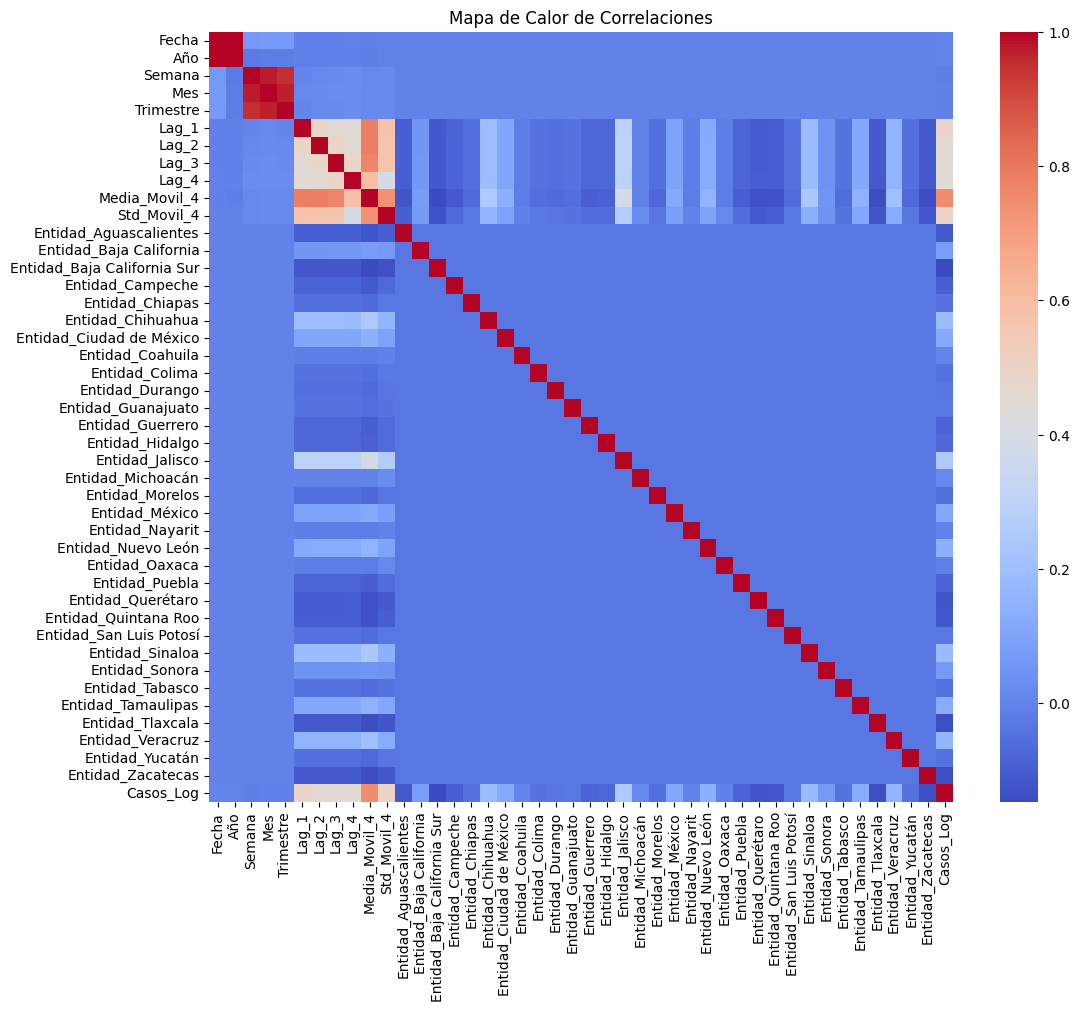

In [427]:
# Se parte del DataFrame df_preparado

# Se realiza el análisis de correlación

# Se calcula la matriz de correlación completa
matriz_corr = df_preparado.corr()

# Se extrae la correlación de todas las características con la variable objetivo
corr_objetivo = matriz_corr['Casos_Log'].abs().sort_values(ascending=False)

print("Correlación de cada característica con 'Casos_Log' (de mayor a menor):\n")
print(corr_objetivo)

# Se visualiza la matriz de correlación completa con un mapa de calor
# Esto es útil para detectar multicolinealidad entre características predictoras.
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_corr, cmap='coolwarm', annot=False) # Se omite annot=True por la gran cantidad de variables
plt.title('Mapa de Calor de Correlaciones')
plt.show()

Las variables con la correlación más alta son: la media móvil, la desviación estándar móvil y los lags. Esto confirma que la historia reciente de la serie es el predictor más fuerte.

Las características basadas en el calendario (Año, Mes, Trimestre, Semana) tienen una correlación casi nula con los casos. Esto indica que no parece haber un ciclo estacional fuerte y consistente en los datos. Por lo tanto, estas características no aportan mucho valor predictivo.

Aunque varias de las columnas Entidad_... aparecen sin mucha correlación con la variable objetivo, hay algunas en la parte media-alta de la lista, lo que indica que saber de qué estado se trata puede marcar pautas de relación con el número de casos.

In [428]:
# Se parte del DataFrame 'df_preparado'

# Se establece la Fecha como el índice antes de la selección
# Esto la separa conceptualmente de las características predictoras.
df_con_indice = df_preparado.set_index('Fecha')


# Se realiza la selección de características

# 1. Se calcula la matriz de correlación sobre el nuevo DataFrame
matriz_corr = df_con_indice.corr()
corr_objetivo = matriz_corr['Casos_Log'].abs().sort_values(ascending=False)

# 2. Se definen las características a eliminar (protegiendo las Entidades)
umbral = 0.01
caracteristicas_baja_corr = corr_objetivo[corr_objetivo < umbral].index.tolist()
columnas_entidad = [col for col in df_con_indice.columns if col.startswith('Entidad_')]
caracteristicas_a_eliminar = [feat for feat in caracteristicas_baja_corr if feat not in columnas_entidad]

# 3. Se crea el DataFrame final sugerido para el modelado
df_final_modelo = df_con_indice.drop(columns=caracteristicas_a_eliminar)

print("Características eliminadas (se protegen Entidades y el índice de Fecha):")
print(caracteristicas_a_eliminar)

print("\nDataFrame final con características seleccionadas e índice de tiempo:")
print(df_final_modelo.head())

Características eliminadas (se protegen Entidades y el índice de Fecha):
['Semana', 'Mes', 'Trimestre', 'Año']

DataFrame final con características seleccionadas e índice de tiempo:
            Lag_1  Lag_2  Lag_3  Lag_4  Media_Movil_4  Std_Movil_4  \
Fecha                                                                
2014-02-09    0.0    0.0    0.0    0.0            0.0          0.0   
2014-02-16    0.0    0.0    0.0    0.0            0.0          0.0   
2014-02-23    0.0    0.0    0.0    0.0            0.0          0.0   
2014-03-02    0.0    0.0    0.0    0.0            0.0          0.0   
2014-03-09    0.0    0.0    0.0    0.0            0.0          0.0   

            Entidad_Aguascalientes  Entidad_Baja California  \
Fecha                                                         
2014-02-09                       1                        0   
2014-02-16                       1                        0   
2014-02-23                       1                        0   
2014-03-02  

SELECCIÓN DE CARACTERÍSTICAS.

Tras la fase de generación de características, el siguiente paso metodológico fue la selección de características. El objetivo fue reducir la dimensionalidad del conjunto de datos, reteniendo únicamente los predictores más influyentes.

La metodología empleada fue el análisis de correlación de Pearson, que cuantifica la relación lineal entre cada característica y la variable objetivo transformada, Casos_Log. El proceso de decisión se basó en los siguientes criterios:
- Identificación de Predictores Débiles: Se estableció un umbral de correlación bajo para identificar las características con una relación lineal muy débil con la variable objetivo. Aquellas variables que no alcanzaron este umbral fueron consideradas candidatas a eliminación por su bajo aporte predictivo.
- Protección de Variables Contextuales: Se aplicó una regla de excepción para proteger todas las columnas Entidad_... (derivadas del One-Hot Encoding) de la eliminación, independientemente de su valor de correlación. Esta decisión se tomó porque aunque individualmente puedan tener una correlación baja, proveen el contexto para que el modelo pueda diferenciar y aprender los patrones específicos de cada estado. Se consideran entonces necesarias para el planteamiento del problema.

Al final, se observó que la hipótesis de que datos temporales como "Semana", "Mes" y "Trimestre" aportarían fuerte información predictiva, no fue acertada.

## 5. Conclusiones

La fase de Preparación de Datos representa una etapa muy importante de la metodología CRISP-ML, ya que la fiabilidad del modelo final está ligada a la calidad de los datos de entrada. En este proyecto, se ha procurado seguir un proceso cuidadoso para transformar el conjunto de datos crudo en un formato que se considera adecuado para la fase de Modelado, basando cada decisión en prácticas de análisis de datos.

El trabajo realizado en esta etapa se puede resumir en las siguientes actividades:

- Selección y Limpieza de Datos: Se inició con la selección de los datos pertinentes al estudio de la "Enfermedad de Alzheimer". Se realizó una limpieza inicial para estandarizar formatos y corregir tipos de datos, buscando establecer una base de trabajo consistente.Asimismo, se optó por reestructurar el DataFrame a un formato más manejable, con una tabla pivoteada. Un paso importante fue la creación de un índice de tiempo formal (Fecha), lo que nos permitió identificar y consolidar registros duplicados. Este tratamiento busca asegurar una mayor integridad en las observaciones de cada entidad a lo largo del tiempo.

- Ingeniería de Características (Feature Engineering): Reconociendo la importancia de enriquecer el dataset, se exploraron y generaron nuevas variables con el objetivo de aumentar el potencial predictivo. Se investigaron y aplicaron técnicas comunes para series de tiempo, resultando en tres tipos de características:
    - Derivadas del Tiempo: Como Mes o Trimestre, para intentar capturar posibles patrones cíclicos.
    - De Retraso (Lags): Para representar la dependencia temporal de la serie.
    - De Ventana Móvil: Para modelar la tendencia y volatilidad local.

- Formateo Final: Para asegurar la compatibilidad con varios algoritmos, se realizaron transformaciones finales. Se utilizó One-Hot Encoding para la variable Entidad, una técnica estándar para variables categóricas sin un orden inherente. Y la variable objetivo, Casos_Semanal_Total, fue sometida a una transformación logarítmica, un procedimiento común para estabilizar la varianza y reducir el sesgo en datos de conteo.

- Selección de Características: Finalmente, se empleó un análisis de correlación como método de filtrado para evaluar la relevancia de las características generadas. Con base en este análisis, se seleccionó un subconjunto de variables, buscando un equilibrio entre la retención de información potencialmente útil y la reducción de la complejidad del modelo, protegiendo siempre las variables (Entidad_...) que consideramos estructuralmente importantes para el problema.

Se considera que el DataFrame resultante, df_final_modelo, constituye una base de trabajo razonable. Si bien cada decisión en esta fase podría ser explorada con mayor profundidad, se cree que el proceso seguido establece un punto de partida sólido para abordar la siguiente fase de Modelado del proyecto.